In [6]:
import pandas as pd 
import numpy as np
df = pd.read_excel("./data/(old)proshares_analysis_data.xlsx", sheet_name="hedge_fund_series")
df.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
df = df.set_index('Date')
annualization_factor = 12


def calc_metrics(data):
    returns_df = pd.DataFrame(index = data.columns) 
    mu = data.mean() * annualization_factor
    vol = data.std() * np.sqrt(annualization_factor)
    sr = mu / vol
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values 
    return returns_df
calc_metrics(df)
    

,Annnualized Return,Annnualized Vol,Annnualized SR
HFRIFWI Index,0.043223,0.060228,0.717668
MLEIFCTR Index,0.031885,0.056966,0.559721
MLEIFCTX Index,0.030399,0.056806,0.535142
HDG US Equity,0.020513,0.059367,0.345534
QAI US Equity,0.019611,0.050062,0.391729


In [8]:
# tail risks

def skewness(data): 
    mu = data.mean()
    numerator = ((data - mu)**(3)).mean()
    denominator = (data.std())**(3) 
    return numerator/denominator 

def kurtosis(data): 
    mu = data.mean()
    numerator = ((data - mu)**(4)).mean()
    denominator = (data.std())**(4) 
    return numerator/denominator 

def value_at_risk(data, quantile): 
    quantile_returns = data.quantile(quantile)
    return quantile_returns 

def cvar(data, quantile): 
    quantile_cut_off = data.quantile(quantile) 
    return data.loc[data.values < quantile_cut_off].mean()

def max_dd(data):
    # something wrong with max dd
    data_df = pd.DataFrame(data)
    data_df['Prev_Peak'] = data_df[data_df.columns[0]].cummax()
    data_df['Drawdown'] = (data_df[data_df.columns[0]] - data_df['Prev_Peak']) / data_df['Prev_Peak']
    max_dd = data_df['Drawdown'].min()
    min_date = data_df['Drawdown'].idxmin()
    peak_date = data_df.loc[:min_date, 'Prev_Peak'].idxmax()
    recovery = min_date - peak_date
    return max_dd, min_date, peak_date, recovery

    

indices = df.columns 
results_df = pd.DataFrame(index = indices)
for index in indices:
    results_df.loc[index, 'Skewness'] = skewness(df[index])
    results_df.loc[index, 'Kurtosis'] = kurtosis(df[index])
    results_df.loc[index, 'VaR'] = value_at_risk(df[index], 0.05)
    results_df.loc[index, 'CVaR'] = cvar(df[index], 0.05)
    results_df.loc[index, 'Max DD'] = max_dd(df[index])[0]
    results_df.loc[index, 'Bottom Date'] = max_dd(df[index])[1]
    results_df.loc[index, 'Peak Date'] = max_dd(df[index])[2]
    results_df.loc[index, 'Recovery'] = max_dd(df[index])[3]
    
results_df
    

,Skewness,Kurtosis,VaR,CVaR,Max DD,Bottom Date,Peak Date,Recovery
HFRIFWI Index,-0.962923,8.555848,-0.025130,-0.037478,-3.593686,2020-03-31,2019-01-31,425 days
MLEIFCTR Index,-0.250558,4.503639,-0.028656,-0.035857,-2.221155,2020-03-31,2011-10-31,3074 days
MLEIFCTX Index,-0.236834,4.472416,-0.028927,-0.035816,-2.209247,2020-03-31,2011-10-31,3074 days
HDG US Equity,-0.238935,4.613877,-0.031158,-0.037576,-2.171158,2020-03-31,2011-10-31,3074 days
QAI US Equity,-0.448920,4.573409,-0.020086,-0.032696,-2.650425,2020-03-31,2015-02-28,1858 days


In [18]:
# regressions 
import statsmodels.api as sm 
spy = pd.read_excel("./data/(old)proshares_analysis_data.xlsx", sheet_name="merrill_factors")
spy.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
spy.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
combined_df = pd.merge(df, spy['SPY US Equity'], on = df.index)
combined_df.rename(columns = {'key_0':'Date'}, inplace=True)
combined_df = combined_df.set_index('Date')


def eval_performance(data, asset):
    y = data[asset]
    x = sm.add_constant(data['SPY US Equity'])
    model = sm.OLS(y, x).fit()
    beta = model.params['SPY US Equity']
    alpha = model.params['const']
    residuals = model.resid 
    std_error = np.std(residuals, ddof=1)

    treynor_ratio = y.mean()/beta 
    information_ratio = alpha/std_error
    
    return beta, treynor_ratio, information_ratio, alpha



assets = df.columns
results_df = pd.DataFrame(index = list(assets), columns = ['Market Beta', 'Treynor Ratio', 'Information Ratio'])
for asset in assets: 
    outcomes = eval_performance(combined_df, asset)
    results_df.loc[asset, 'Alpha'] = outcomes[3] * annualization_factor
    results_df.loc[asset, 'Market Beta'] = outcomes[0]
    results_df.loc[asset, 'Treynor Ratio'] = outcomes[1] * np.sqrt(annualization_factor)
    results_df.loc[asset, 'Information Ratio'] = outcomes[2] * np.sqrt(annualization_factor)
    
results_df
    


,Market Beta,Treynor Ratio,Information Ratio,Alpha
HFRIFWI Index,0.348706,0.035782,-0.100529,-0.003238
MLEIFCTR Index,0.34962,0.026327,-0.580287,-0.014698
MLEIFCTX Index,0.348325,0.025194,-0.631588,-0.016011
HDG US Equity,0.359366,0.016478,-0.983914,-0.027368
QAI US Equity,0.296053,0.019122,-0.784446,-0.019835


The alphas are negative which suggest that these indices did not provide any outperformance and they all underperformed. 
Nonetheless, as their betas are positive, they have some positive influence on the SPY. However, when we include the standard errors and obtain the information ratios, they indicate a strong underperformance.

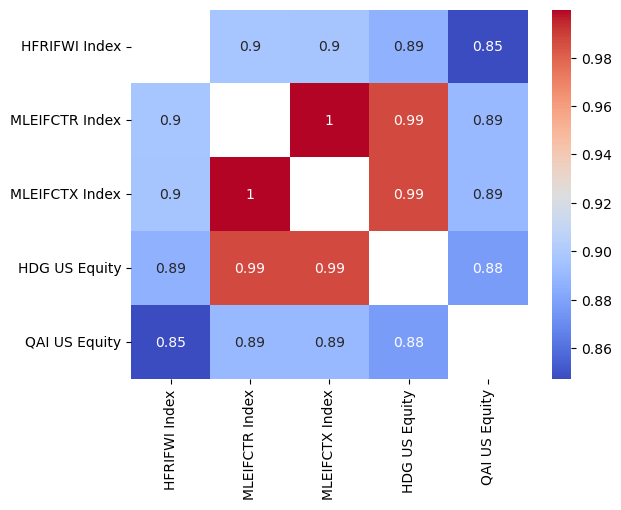

In [190]:
# corr mtx 
corr_mtx = df.corr() 
import seaborn as sns

mask = np.eye(corr_mtx.shape[0], dtype=bool)
sns.heatmap(corr_mtx, mask=mask, annot=True, cmap='coolwarm')
plt.show()



In [43]:
corr_mtx

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
HFRIFWI Index,1.000000,0.896947,0.896296,0.886021,0.847084
MLEIFCTR Index,0.896947,1.000000,0.999921,0.987349,0.890510
MLEIFCTX Index,0.896296,0.999921,1.000000,0.987167,0.890098
HDG US Equity,0.886021,0.987349,0.987167,1.000000,0.876680
QAI US Equity,0.847084,0.890510,0.890098,0.876680,1.000000


In [81]:
#Q6 
merill_factors = pd.read_excel("./data/(old)proshares_analysis_data.xlsx", sheet_name="merrill_factors")
merill_factors.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
merill_factors.set_index('Date', inplace =True)
factors = list(merill_factors.columns)

combined_df = pd.merge(merill_factors, df['HFRIFWI Index'], on = merill_factors.index)
combined_df.rename(columns = {'key_0':'Date'}, inplace=True)
combined_df.set_index('Date', inplace=True)

def get_params(data, y_col='HFRIFWI Index', x_col=factors):
    columns = ['Alpha', 'R-Squared'] + x_col + ['P-Value (Alpha)'] + [f'P-Value ({col})' for col in x_col]
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    betas = model.params
    p_values = model.pvalues
    parameters = [0] + [r_squared] + list(betas) + [None] + list(p_values)
    params_df['Without Intercept'] = parameters
    
    x = sm.add_constant(x)
    model_alpha = sm.OLS(y, x).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    p_values_model_alpha = model_alpha.pvalues
    alpha_p_value = p_values_model_alpha[0]
    beta_p_values = p_values_model_alpha[1:]
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) + [alpha_p_value] + list(beta_p_values)
    params_df['With Intercept'] = parameters

    return params_df 

get_params(combined_df)


/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/3117134969.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_model_alpha = model_alpha.params[0]
/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/3117134969.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_p_value = p_values_model_alpha[0]


,Without Intercept,With Intercept
Alpha,0.000000e+00,1.382796e-03
R-Squared,8.399260e-01,8.369008e-01
SPY US Equity,5.085780e-02,3.330796e-02
USGG3M Index,3.377871e-01,-1.659079e-01
EEM US Equity,7.763866e-02,7.785673e-02
EFA US Equity,7.525306e-02,8.241002e-02
EUO US Equity,2.563619e-02,2.264931e-02
IWM US Equity,1.485562e-01,1.520744e-01
P-Value (Alpha),NaN,7.170886e-02
P-Value (SPY US Equity),1.677798e-01,3.777705e-01


betas are all < 1 which suggests no outperformance. 
However, their p values are > 0.05 which suggest a lack of statistical relationship given the presence of multicollinearity amongst the features. 

In [65]:
(model.resid).std()*100

0.702151743373105

In [128]:
#Q7

combined_df = combined_df.reset_index()
oos_data = merill_factors.copy()
is_data = combined_df.loc[:60].set_index('Date')

columns = list(merill_factors.columns) 

In [130]:
# regression estimation 
def regression(data: pd.DataFrame):
    y = data['HFRIFWI Index']
    x = sm.add_constant(data[columns])
    model = sm.OLS(y,x).fit() 
    return model

# in sample testing 
model = regression(is_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     54.76
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           3.34e-21
Time:                        09:21:44   Log-Likelihood:                 233.44
No. Observations:                  61   AIC:                            -452.9
Df Residuals:                      54   BIC:                            -438.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.001     -0.404      0.687      -0.003       0.002
SPY US Equity     0.0898      0.057      1.563      0.124      -0.025       0.205
USGG3M Index      9.7105     10.044      0.967      0.338     -10.426      29.847
EEM US Equity     0.0495      0.026      1.921      0.060      -0.002       0.101
EFA US Equity     0.1204      0.042      2.836      0.006       0.035       0.205
EUO US Equity     0.0232      0.018      1.315      0.194      -0.012       0.058
IWM US Equity     0.0732      0.034      2.185      0.033       0.006       0.140
==============================================================================
Omnibus:                        2.693   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.957
Skew:                          -0.419   Prob(JB):                        0.376
Kurtosis:                       3.261   Cond. No.                     1.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:
start = 60 
summary = pd.DataFrame()
data = combined_df.copy()
for i in range(start, len(data), 1): 
    is_data = data.loc[i - 60:i, :]
    y = is_data['HFRIFWI Index']
    x = sm.add_constant(is_data[columns]) 
    model = sm.OLS(y, x).fit() 

    oos_x = data.loc[i, columns]
    oos_y = data.loc[i, 'HFRIFWI Index']
    date = data.loc[i, 'Date']
    
    y_pred = model.params[0] + (model.params[1:] @ oos_x)
    summary.loc[date, 'actual'] = oos_y
    summary.loc[date, 'replicated'] = y_pred



    

/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + (model.params[1:] @ oos_x)
/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + (model.params[1:] @ oos_x)
/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

In [134]:
oos_rsquared = (
    1 - (summary["actual"] - summary["replicated"]).var() / summary["actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")


OOS-R-Squared: 88.05%


Text(0.5, 1.0, 'Actual vs Replicated values')

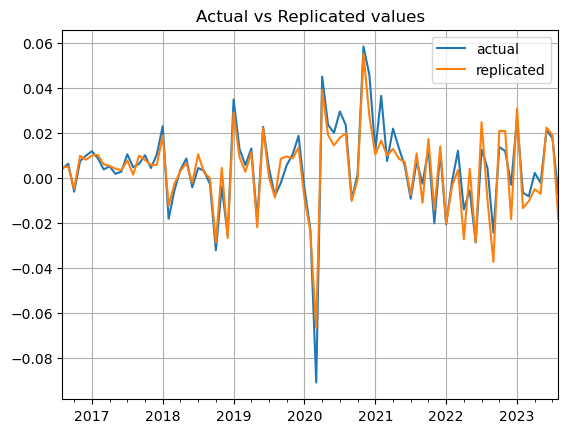

In [120]:
summary.plot()
plt.grid(True)

plt.title('Actual vs Replicated values')

In [184]:
# full sample replication


def full_sample_replication(data, y_col='HFRIFWI Index', x_col=factors):
    columns = ['Alpha', 'R-Squared'] + x_col 
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    betas = model.params
    parameters = [0] + [r_squared] + list(betas)
    params_df['Without Intercept'] = parameters

    fitted_mean = (betas @ x.mean()) * 12
    
    
    x_alpha = sm.add_constant(x)
    model_alpha = sm.OLS(y, x_alpha).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) 
    params_df['With Intercept'] = parameters


    fitted_mean_alpha = (alpha_model_alpha + betas_model_alpha @ x.mean()) * 12
                   

    return params_df, fitted_mean, fitted_mean_alpha, y.mean() * 12

params_df, fitted_mean, fitted_mean_alpha, actual_mean = full_sample_replication(combined_df)
params_df

/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_1614/3700295908.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_model_alpha = model_alpha.params[0]


,Without Intercept,With Intercept
Alpha,0.000000,0.001383
R-Squared,0.839926,0.836901
SPY US Equity,0.050858,0.033308
USGG3M Index,0.337787,-0.165908
EEM US Equity,0.077639,0.077857
EFA US Equity,0.075253,0.082410
EUO US Equity,0.025636,0.022649
IWM US Equity,0.148556,0.152074


In [186]:
fitted_mean, fitted_mean_alpha, actual_mean

(0.0330816977418035, 0.043223433346801864, 0.04322343334679223)